# Kaggle - Yelp Restaurant Photo Classification

## Look at training data set
Examine files: 
- `train_photo_to_biz_ids.csv` - maps the photo id to business id
- `train.csv` - main training dataset. Includes the business id's, and their corresponding labels


In [1]:
library('ggplot2')
library('plyr')
data_root = '/home/cathy/repos/kaggle-yelp/'

## Look at photos assigned to business ids

In [2]:
photo_to_biz = read.table(file.path(data_root, 'train_photo_to_biz_ids.csv'), header=T, sep=",", colClasses=c("integer", "character"))

In [3]:
head(photo_to_biz)

,photo_id,business_id
1,204149,3034
2,52779,2805
3,278973,485
4,195284,485
5,19992,485
6,80748,485


In [4]:
nrow(photo_to_biz)

[1] 234842

In [5]:
# Make a dataframe with columns business_id, num_photos (# of photos/instances for that business)
photos_per_biz = table(photo_to_biz$business_id)
photos_per_biz = data.frame(business_id = names(photos_per_biz), num_photos = as.vector(photos_per_biz))
head(photos_per_biz)

,business_id,num_photos
1,100,84
2,1000,54
3,1001,9
4,1006,22
5,101,121
6,1010,11


stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


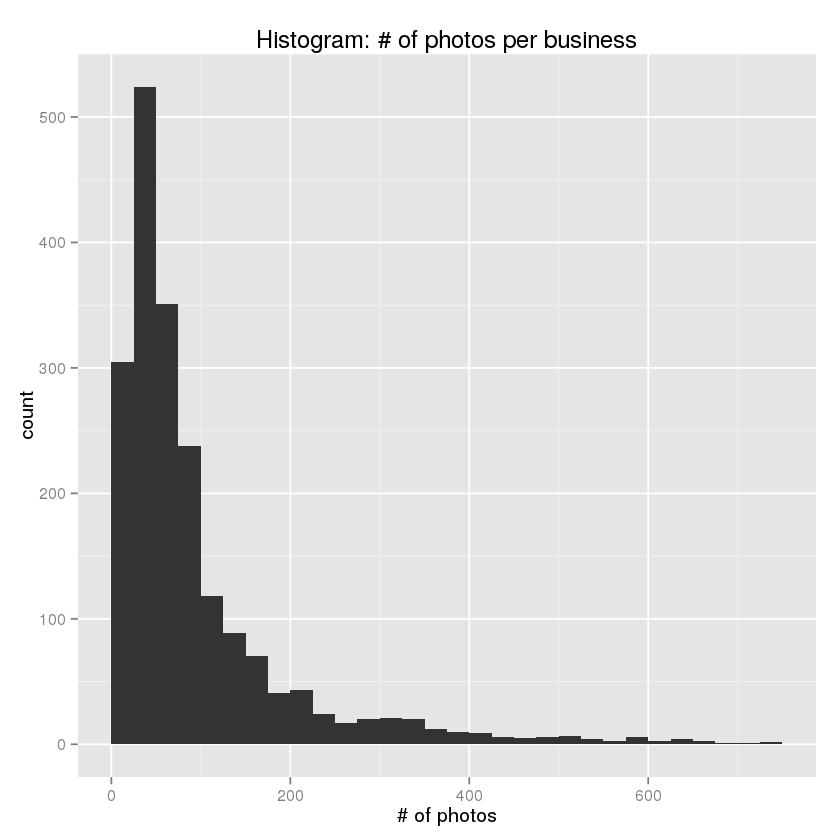

In [7]:
ggplot(photos_per_biz, aes(num_photos)) + geom_histogram() + xlim(0,750) + xlab('# of photos') + ggtitle('Histogram: # of photos per business')

In [8]:
summary(photos_per_biz$num_photos)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0    34.0    61.0   117.4   117.0  2974.0 

In [9]:
sum(is.na(photos_per_biz$num_photos))

[1] 0

## Look at labels assigned to businesses

In [12]:
#############################  Yelp Attributes #############################
#0: good_for_lunch                    5: has_alcohol
#1: good_for_dinner                   6: has_table_service  
#2: takes_reservations                7: ambience_is_classy
#3: outdoor_seating                   8: good_for_kids
#4: restaurant_is_expensive
############################################################################

In [17]:
biz_labels = read.table(file.path(data_root, 'train.csv'), header=T, sep=",", colClasses=c("character", "character"))

In [18]:
head(biz_labels)

,business_id,labels
1,1000,1 2 3 4 5 6 7
2,1001,0 1 6 8
3,100,1 2 4 5 6 7
4,1006,1 2 4 5 6
5,1010,0 6 8
6,101,1 2 3 4 5 6


In [19]:
# how many businesses are there in the training set?
nrow(biz_labels)

## double check-- any duplicated business ids?
length(unique(biz_labels$business_id))

[1] 2000

[1] 2000

Split string of labels into vector per business, then count how many labels there are per business.

In [20]:
biz_labels$labels <- strsplit(biz_labels$labels, ' ')
biz_labels$label_count <- sapply(biz_labels$labels, length)
head(biz_labels)

,business_id,labels,label_count
1,1000,"1, 2, 3, 4, 5, 6, 7",7
2,1001,"0, 1, 6, 8",4
3,100,"1, 2, 4, 5, 6, 7",6
4,1006,"1, 2, 4, 5, 6",5
5,1010,"0, 6, 8",3
6,101,"1, 2, 3, 4, 5, 6",6


In [231]:
sum(biz_labels$label_count > 9)

[1] 0

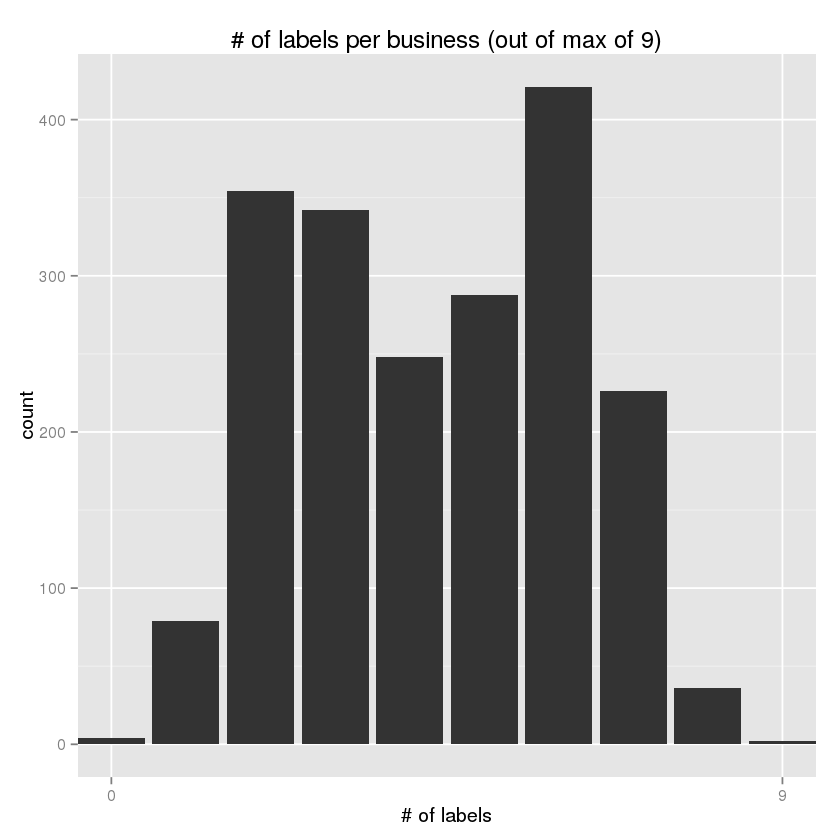

In [31]:
ggplot(biz_labels, aes(label_count)) + geom_histogram(binwidth=1) + scale_x_discrete("# of labels", limits=c(0,9)) + ggtitle("# of labels per business (out of max of 9)")

Which businesses have no labels?

In [32]:
biz_labels[biz_labels$label_count==0, ]

,business_id,labels,label_count
386,1627,,0
929,2661,,0
1084,2941,,0
1679,430,,0


Which businesses have all 9 labels?

In [34]:
biz_labels[biz_labels$label_count == 9, ]

,business_id,labels,label_count
559,1954,"0, 1, 2, 3, 4, 5, 6, 7, 8",9
1033,285,"0, 1, 2, 3, 4, 5, 6, 7, 8",9


How many of each type of label is present?

In [35]:
table(unlist(biz_labels$labels))


   0    1    2    3    4    5    6    7    8 
 671  993 1026 1003  547 1249 1360  572 1238 

Merge dataframes photos_per_biz and biz_labels 

In [36]:
df = merge(x=photos_per_biz, y=biz_labels, by="business_id")

In [37]:
head(df)

,business_id,num_photos,labels,label_count
1,100,84,"1, 2, 4, 5, 6, 7",6
2,1000,54,"1, 2, 3, 4, 5, 6, 7",7
3,1001,9,"0, 1, 6, 8",4
4,1006,22,"1, 2, 4, 5, 6",5
5,101,121,"1, 2, 3, 4, 5, 6",6
6,1010,11,"0, 6, 8",3


What is the correlation between num_photos and label_count? e.g. do a greater number of photos mean more labels?

In [38]:
# correlation coefficient
cor(df$num_photos, df$label_count)

[1] 0.1327423

In [39]:
cor.test(df$num_photos, df$label_count)


	Pearson's product-moment correlation

data:  df$num_photos and df$label_count
t = 5.9864, df = 1998, p-value = 2.536e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.08943171 0.17555184
sample estimates:
      cor 
0.1327423 


## Transform the vectors of labels into dataframe of one-hot encoding per label (1 for label, 0 for no label for a particular category)

In [40]:
# first create matrix of zeros, dimension 2000 (# of business ids) x 9 (# of labels)
labels_OHE = matrix(0, nrow=nrow(df), ncol=9)
colnames(labels_OHE) = as.character(seq(0,8))
rownames(labels_OHE) = df$business_id
head(labels_OHE)

,0,1,2,3,4,5,6,7,8
100,0,0,0,0,0,0,0,0,0
1000,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,0,0,0
1006,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0
1010,0,0,0,0,0,0,0,0,0


In [44]:
# replace 0 with 1 for each corresponding label in df$labels

labels_per_biz_list = dlply(biz_labels[c('business_id','labels')], .(business_id), function(x) as.integer(unlist(x['labels'][[1]])))
head(labels_per_biz_list)
    
for (id in names(labels_per_biz_list)) {
    labels_OHE[id, labels_per_biz_list[[id]]+1] = 1
}
head(labels_OHE)

$`100`
[1] 1 2 4 5 6 7

$`1000`
[1] 1 2 3 4 5 6 7

$`1001`
[1] 0 1 6 8

$`1006`
[1] 1 2 4 5 6

$`101`
[1] 1 2 3 4 5 6

$`1010`
[1] 0 6 8

,0,1,2,3,4,5,6,7,8
100,0,1,1,0,1,1,1,1,0
1000,0,1,1,1,1,1,1,1,0
1001,1,1,0,0,0,0,1,0,1
1006,0,1,1,0,1,1,1,0,0
101,0,1,1,1,1,1,1,0,0
1010,1,0,0,0,0,0,1,0,1


In [48]:
# create a data frame from the matrix
labels_OHE_df = as.data.frame(labels_OHE)
names(labels_OHE_df) = c('0: good_for_lunch', '1: good_for_dinner', '2: takes_reservations', 
                         '3: outdoor_seating','4: restaurant_is_expensive','5: has_alcohol',
                         '6: has_table_service', '7: ambience_is_classy','8: good_for_kids')

# How many times does each label appear in the training set?
sort(apply(labels_OHE_df, 2, sum))

4: restaurant_is_expensive      7: ambience_is_classy 
                       547                        572 
         0: good_for_lunch         1: good_for_dinner 
                       671                        993 
        3: outdoor_seating      2: takes_reservations 
                      1003                       1026 
          8: good_for_kids             5: has_alcohol 
                      1238                       1249 
      6: has_table_service 
                      1360

## Plot pairwise correlations between labels

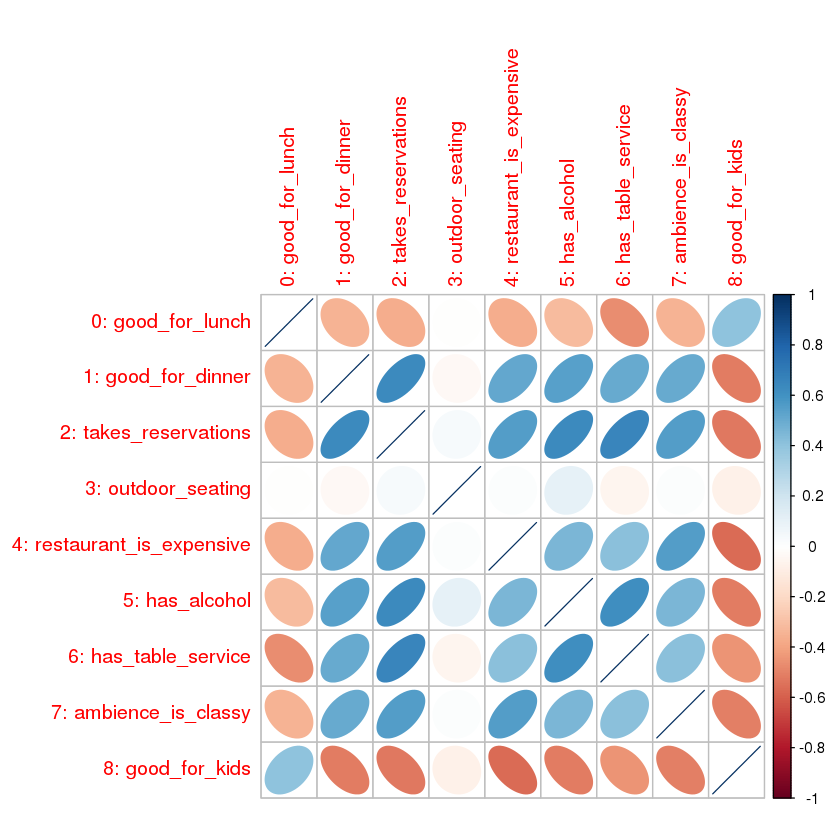

In [47]:
library('corrplot')

# plot pairwise correlations of labels
corrplot(cor(labels_OHE_df), method="ellipse")

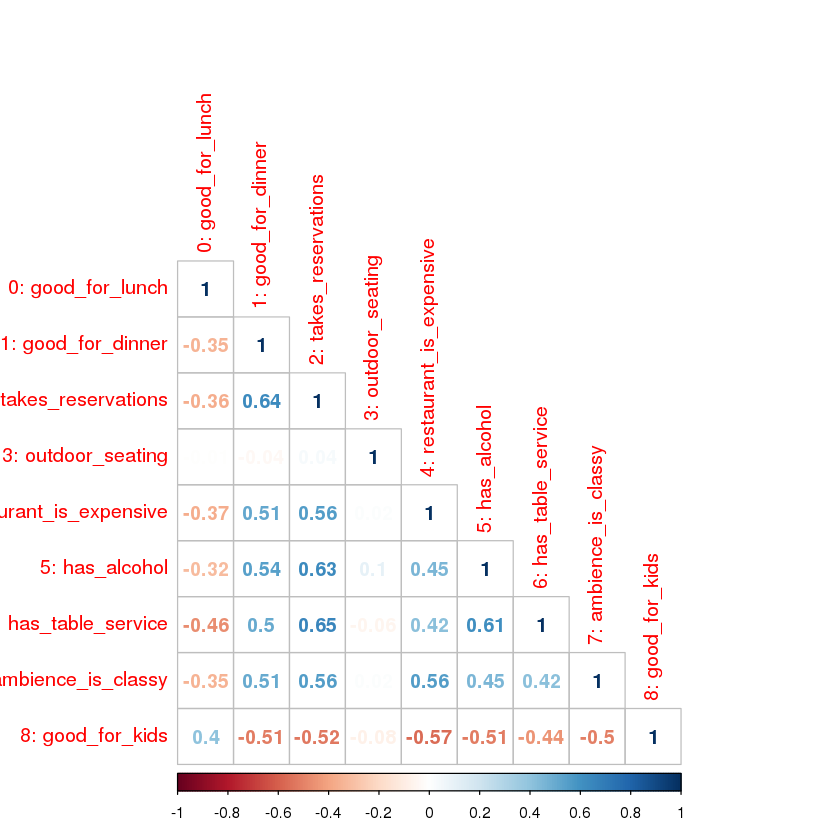

In [49]:
corrplot(cor(labels_OHE_df), method="number", type="lower")